In [1]:
import requests
import pandas as pd
from io import StringIO
import datetime
from pathlib import Path
from talib import RSI, BBANDS, MACD, NATR, ATR, OBV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import h5py
import json
import os
import re
import PyPDF2

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from transformers import pipeline

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import statsmodels.api as sm

In [2]:
#Return format => json
def get_intraday_data(ticker, start, to, interval, outputFile, api_token="629395b0a5ac24.13075788", session=None):
    if session is None:
        session = requests.Session()
        url = "https://eodhistoricaldata.com/api/intraday/"+ ticker+ "?api_token={YOUR_API_KEY}&interval={interval}&from={start}&to={to}&fmt=json"
        params = {'ticker': ticker,'api_token': api_token, 'interval': interval, 'from': start, 'to': to}
        r = session.get(url, params=params)
        if r.status_code == requests.codes.ok:
            data = r.json()
            with h5py.File(outputFile, 'w') as f:
                json_data = json.dumps(data)
                f.create_dataset('json', data=json_data.encode('utf8'))
        else:
            print(r)
            raise Exception(r.status_code, r.reason, url)


In [ ]:
#/!/ Run it once

#Getting S&P500 data
for year in range(2020,2024):
    start = datetime.datetime(year, 1, 1).timestamp()
    end = datetime.datetime(year+1, 1, 1).timestamp()
    get_intraday_data("GSPC.INDX", start, end, "5m", "C:/Users/dell/Desktop/Trading Project/"+str(year)+".h5")


In [3]:
directory_path = "C:/Users/dell/Desktop/Trading Project/"

# List all the files in the directory
files = [f for f in os.listdir(directory_path) if f.endswith('.h5')]
all_dataframe = pd.DataFrame()

for file in files:
    with h5py.File(os.path.join(directory_path, file), 'r') as f: 
        # read the JSON data from the 'json' dataset
        json_data = f['json'][()]
        # convert the JSON data back into a dictionary
        data_dict = json.loads(json_data)
        # convert the dictionary into a DataFrame
        df = pd.DataFrame.from_dict(data_dict)
        all_dataframe = all_dataframe.append(df, ignore_index=True)

all_dataframe.set_index('datetime', inplace=True)
all_dataframe.index = pd.to_datetime(all_dataframe.index)
data = all_dataframe.copy()


C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2264865684.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dataframe = all_dataframe.append(df, ignore_index=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2264865684.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dataframe = all_dataframe.append(df, ignore_index=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2264865684.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dataframe = all_dataframe.append(df, ignore_index=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2264865684.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dataframe = 

In [4]:
# S&P 500 data preprocessing

# Fill Missing Values with Previous Values
data_filled = data.fillna(method='ffill')

# Convert 'volume' column to float
data_filled['volume'] = data_filled['volume'].astype(float)

# Reassemble data by 30 minutes
data_reassembled = data_filled.resample('30T').last()

# Forward fill missing values in the reassembled data
data_reassembled_filled = data_reassembled.fillna(method='ffill')


In [6]:
# Check for NaN values in the dataset
nan_check = data_reassembled_filled.isna().any()

# Print the columns with NaN values
print(nan_check)

timestamp    False
gmtoffset    False
open         False
high         False
low          False
close        False
volume       False
dtype: bool


In [7]:
data_reassembled_filled["date"] = data_reassembled_filled.index.date

In [8]:
data2 = data.copy()

In [9]:
# Convert 'volume' column to float
data['volume'] = data['volume'].astype(float)

In [10]:
#Checking days where we have no prices and no volumes
#Group the data by 'day' and check if all values within each group are NaN for both 'open' and 'volume' columns
missing_days_mask = data_reassembled_filled.groupby('date').apply(lambda x: x[['open', 'volume']].isna().all().all())


# Filter the dates with all NaN values in 'open' and 'volume' columns
missing_days = missing_days_mask[missing_days_mask].index

# Print the missing days
print(missing_days)

Index([], dtype='object', name='date')


In [11]:
#Checking days where we have no volumes

#Note: should we takes only days where volume reach a certain treshold? 
missing_days_mask2 = data_reassembled_filled.groupby('date').apply(lambda x: x[['volume']].isna().all().all())
missing_days2 = missing_days_mask[missing_days_mask2].index
print(missing_days2)

Index([], dtype='object', name='date')


In [ ]:
#Getting the vix data

#/!/ Run it once
for year in range(2013,2024):
    start = datetime.datetime(year, 1, 1).timestamp()
    end = datetime.datetime(year+1, 1, 1).timestamp()
    get_intraday_data("VIX.INDX", start, end, "5m", "C:/Users/dell/Desktop/Trading Project/Vix"+str(year)+".h5")

#/!/ End Run it once

In [12]:
directory_path = "C:/Users/dell/Desktop/Trading Project"

# List all the files in the directory
files = [f for f in os.listdir(directory_path) if f.startswith('Vix')]
vix_dataframe = pd.DataFrame()

for file in files:
    with h5py.File(os.path.join(directory_path, file), 'r') as f: 
        # read the JSON data from the 'json' dataset
        json_data = f['json'][()]
        # convert the JSON data back into a dictionary
        data_dict = json.loads(json_data)
        # convert the dictionary into a DataFrame
        df = pd.DataFrame.from_dict(data_dict)
        vix_dataframe = vix_dataframe.append(df, ignore_index=True)

vix_dataframe.set_index('datetime', inplace=True)
vix_dataframe = vix_dataframe.rename(columns={'open': 'vixLevel'})

vix_dataframe

C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2502697082.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vix_dataframe = vix_dataframe.append(df, ignore_index=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2502697082.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vix_dataframe = vix_dataframe.append(df, ignore_index=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2502697082.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vix_dataframe = vix_dataframe.append(df, ignore_index=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2502697082.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vix_dataframe = 

,timestamp,gmtoffset,vixLevel,high,low,close,volume
datetime,,,,,,,
2020-02-26 14:30:00,1582727400,0,25.81,25.970000,25.690000,25.880000,None
2020-02-26 14:35:00,1582727700,0,26.02,26.020000,25.460000,25.480000,None
2020-02-26 14:40:00,1582728000,0,25.43,25.440000,24.850000,24.960000,None
2020-02-26 14:45:00,1582728300,0,24.98,25.410000,24.970000,25.360000,None
2020-02-26 14:50:00,1582728600,0,25.36,25.600000,25.290000,25.340000,None
...,...,...,...,...,...,...,...
2023-05-24 12:30:00,1684931400,0,19.52,19.739999,19.520000,19.739999,None
2023-05-24 12:35:00,1684931700,0,19.70,19.729999,19.649999,19.649999,None
2023-05-24 12:40:00,1684932000,0,19.67,19.739999,19.670000,19.680000,None


In [13]:
# Convert the index of vix_dataframe to DatetimeIndex
vix_dataframe.index = pd.to_datetime(vix_dataframe.index)

# Fill missing values in vix_dataframe using forward-fill
vix_dataframe.ffill(inplace=True)



In [14]:
# Resample VIX dataframe to 30-minute intervals
vix_dataframe_resampled = vix_dataframe.resample('30T').ffill()

In [17]:
vix_dataframe = vix_dataframe_resampled

In [18]:
all_dataframe = data_reassembled_filled

In [20]:
all_dataframe

,timestamp,gmtoffset,open,high,low,close,volume,date
datetime,,,,,,,,
2020-02-24 14:30:00,1.582556e+09,0.0,3256.689940,3256.830080,3251.489990,3254.600100,36716671.0,2020-02-24
2020-02-24 15:00:00,1.582558e+09,0.0,3247.649900,3248.870120,3244.510010,3245.389890,31269796.0,2020-02-24
2020-02-24 15:30:00,1.582560e+09,0.0,3249.189940,3250.229980,3248.020020,3249.580080,24787790.0,2020-02-24
2020-02-24 16:00:00,1.582562e+09,0.0,3247.419920,3247.520020,3243.879880,3244.939940,21411709.0,2020-02-24
2020-02-24 16:30:00,1.582563e+09,0.0,3235.080080,3241.419920,3232.590090,3237.270020,24604999.0,2020-02-24
...,...,...,...,...,...,...,...,...
2023-05-23 18:00:00,1.684866e+09,0.0,4144.879882,4150.890136,4142.540039,4148.660156,27731000.0,2023-05-23
2023-05-23 18:30:00,1.684868e+09,0.0,4152.140136,4153.330078,4151.529785,4152.580078,18008000.0,2023-05-23
2023-05-23 19:00:00,1.684870e+09,0.0,4151.680175,4152.770019,4150.589843,4152.600097,22705000.0,2023-05-23


In [21]:
#Adding the vix feature to the existing dataframe
all_dataframe = all_dataframe.merge(vix_dataframe[['vixLevel']], left_index=True, right_index=True, how='left')
all_dataframe["vixLevel"] = all_dataframe['vixLevel'].fillna(method="ffill")
all_dataframe["vixLevel"] = all_dataframe['vixLevel'].fillna(method="bfill")
all_dataframe

,timestamp,gmtoffset,open,high,low,close,volume,date,vixLevel
datetime,,,,,,,,,
2020-02-24 14:30:00,1.582556e+09,0.0,3256.689940,3256.830080,3251.489990,3254.600100,36716671.0,2020-02-24,25.810000
2020-02-24 15:00:00,1.582558e+09,0.0,3247.649900,3248.870120,3244.510010,3245.389890,31269796.0,2020-02-24,25.810000
2020-02-24 15:30:00,1.582560e+09,0.0,3249.189940,3250.229980,3248.020020,3249.580080,24787790.0,2020-02-24,25.810000
2020-02-24 16:00:00,1.582562e+09,0.0,3247.419920,3247.520020,3243.879880,3244.939940,21411709.0,2020-02-24,25.810000
2020-02-24 16:30:00,1.582563e+09,0.0,3235.080080,3241.419920,3232.590090,3237.270020,24604999.0,2020-02-24,25.810000
...,...,...,...,...,...,...,...,...,...
2023-05-23 18:00:00,1.684866e+09,0.0,4144.879882,4150.890136,4142.540039,4148.660156,27731000.0,2023-05-23,18.399999
2023-05-23 18:30:00,1.684868e+09,0.0,4152.140136,4153.330078,4151.529785,4152.580078,18008000.0,2023-05-23,18.850000
2023-05-23 19:00:00,1.684870e+09,0.0,4151.680175,4152.770019,4150.589843,4152.600097,22705000.0,2023-05-23,18.569999


In [22]:
# Check for NaN values in the dataset
nan_check = all_dataframe.isna().any()

# Print the columns with NaN values
print(nan_check)

timestamp    False
gmtoffset    False
open         False
high         False
low          False
close        False
volume       False
date         False
vixLevel     False
dtype: bool


If the GDP release date occurs once a month, and the merged DataFrame contains NaN values for most of the rows, one approach to handle this is to forward-fill the NaN values with the last available GDP value. This way, the GDP value will be carried forward until the next release date.

In [23]:
#Adding les disc_features: US GDP
df_disct_features = pd.read_excel("C:/Users/dell/Desktop/Trading Project/nouamanTest.xlsx", sheet_name=['CPI', 'MICHIGAN', 'GDP'])

# Convert the 'Release Date' column to datetime with specified format
df_disct_features['GDP']['Release Date'] = pd.to_datetime(df_disct_features['GDP']['Release Date'], format='%d/%m/%Y')
df_disct_features['GDP']["Date"] = df_disct_features['GDP'].apply(lambda row: datetime.datetime.combine(row['Release Date'], row['Time']), axis=1)
df_disct_features['GDP'].set_index('Date', inplace=True)

all_dataframe = all_dataframe.merge(df_disct_features['GDP'][["GDP_ACTUAL", 'GDP_FORECAST']], left_index=True, right_index=True, how='left')

# Forward-fill missing values in the GDP columns on a monthly basis
all_dataframe[['GDP_ACTUAL', 'GDP_FORECAST']] = all_dataframe[['GDP_ACTUAL', 'GDP_FORECAST']].fillna(method='ffill', limit=1, axis=0)

# Backward-fill any remaining missing values
all_dataframe[['GDP_ACTUAL', 'GDP_FORECAST']] = all_dataframe[['GDP_ACTUAL', 'GDP_FORECAST']].fillna(method='bfill')

# Replace any remaining NaN values with 0
all_dataframe[['GDP_ACTUAL', 'GDP_FORECAST']] = all_dataframe[['GDP_ACTUAL', 'GDP_FORECAST']].fillna(0)

# Create a new column indicating whether GDP data is available (not NaN or 0)
all_dataframe['isGdpRelease'] = all_dataframe['GDP_ACTUAL'].notna() & (all_dataframe['GDP_ACTUAL'] != 0)


In [24]:
#Adding les disc_features: Michigan
df_disct_features['MICHIGAN']['Release Date'] = pd.to_datetime(df_disct_features['MICHIGAN']['Release Date'], format='%d/%m/%Y')
df_disct_features['MICHIGAN']["Date"] = df_disct_features['MICHIGAN'].apply(lambda row: datetime.datetime.combine(row['Release Date'], row['Time']), axis=1)
df_disct_features['MICHIGAN'].set_index('Date', inplace=True)

# Merge Michigan data with the all_dataframe
all_dataframe = all_dataframe.merge(df_disct_features['MICHIGAN'][["MICHIGAN_ACTUAL", 'MICHIGAN_FORECAST']], left_index=True, right_index=True, how='left')

# Forward-fill missing values in the Michigan columns on a monthly basis
all_dataframe[['MICHIGAN_ACTUAL', 'MICHIGAN_FORECAST']] = all_dataframe[['MICHIGAN_ACTUAL', 'MICHIGAN_FORECAST']].fillna(method='ffill', limit=1)

# Backward-fill any remaining missing values
all_dataframe[['MICHIGAN_ACTUAL', 'MICHIGAN_FORECAST']] = all_dataframe[['MICHIGAN_ACTUAL', 'MICHIGAN_FORECAST']].fillna(method='bfill')

# Replace any remaining NaN values with 0
all_dataframe[['MICHIGAN_ACTUAL', 'MICHIGAN_FORECAST']] = all_dataframe[['MICHIGAN_ACTUAL', 'MICHIGAN_FORECAST']].fillna(0)

# Create a new column indicating whether Michigan data is available (not NaN or 0)
all_dataframe['isMichiganRelease'] = all_dataframe['MICHIGAN_ACTUAL'].notna() & (all_dataframe['MICHIGAN_ACTUAL'] != 0)


In [25]:
#Adding les disc_features: CPI
df_disct_features['CPI']['Release Date'] = pd.to_datetime(df_disct_features['CPI']['ReleaseDate'], format='%d/%m/%Y')
df_disct_features['CPI']["Date"] = df_disct_features['CPI'].apply(lambda row: datetime.datetime.combine(row['ReleaseDate'], row['Time']), axis=1)
df_disct_features['CPI'].set_index('Date', inplace=True)
all_dataframe = all_dataframe.merge(df_disct_features['CPI'][["CPI_ACTUAL"]], left_index=True, right_index=True, how='left')

# Forward-fill missing values in the CPI columns on a monthly basis
all_dataframe[["CPI_ACTUAL"]] = all_dataframe[["CPI_ACTUAL"]].fillna(method='ffill', limit=1)

# Backward-fill any remaining missing values
all_dataframe[["CPI_ACTUAL"]] = all_dataframe[["CPI_ACTUAL"]].fillna(method='bfill')

# Replace any remaining NaN values with 0
all_dataframe[["CPI_ACTUAL"]] = all_dataframe[["CPI_ACTUAL"]].fillna(0)

# Create a new column indicating whether CPI data is available (not NaN or 0)
all_dataframe['isCpiRelease'] = all_dataframe['CPI_ACTUAL'].notna() & (all_dataframe['CPI_ACTUAL'] != 0)

In [26]:
# Check for NaN values in the dataset
nan_check = all_dataframe.isna().any()

# Print the columns with NaN values
print(nan_check)

timestamp            False
gmtoffset            False
open                 False
high                 False
low                  False
close                False
volume               False
date                 False
vixLevel             False
GDP_ACTUAL           False
GDP_FORECAST         False
isGdpRelease         False
MICHIGAN_ACTUAL      False
MICHIGAN_FORECAST    False
isMichiganRelease    False
CPI_ACTUAL           False
isCpiRelease         False
dtype: bool


In [27]:
data

,timestamp,gmtoffset,open,high,low,close,volume
datetime,,,,,,,
2020-02-24 14:30:00,1582554600,0,3257.610110,3257.610110,3231.520020,3244.600100,78087369.0
2020-02-24 14:35:00,1582554900,0,3244.550050,3254.600100,3244.020020,3254.030030,65390726.0
2020-02-24 14:40:00,1582555200,0,3253.750000,3254.149900,3246.080080,3254.149900,56013945.0
2020-02-24 14:45:00,1582555500,0,3254.280030,3257.550050,3253.360110,3255.159910,47925261.0
2020-02-24 14:50:00,1582555800,0,3254.159910,3257.750000,3251.989990,3256.600100,42401034.0
...,...,...,...,...,...,...,...
2023-05-23 19:40:00,1684870800,0,4153.620117,4154.220214,4152.049804,4154.049804,33770000.0
2023-05-23 19:45:00,1684871100,0,4154.089843,4155.850097,4152.310058,4153.500000,41461000.0
2023-05-23 19:50:00,1684871400,0,4153.490234,4153.490234,4148.040039,4148.379882,73131000.0


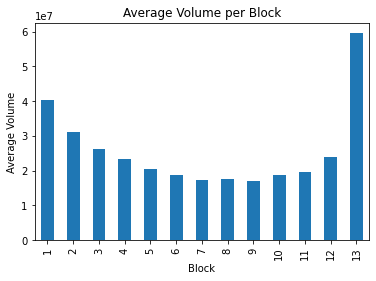

In [28]:
# Resample the original dataframe to 30-minute intervals and calculate mean values
df_30min = data.resample('30T').mean().dropna(subset=['open', 'volume'])

# Create a new column 'Block' that assigns a block number to each 30-minute interval based on the date
df_30min["Block"] = df_30min.groupby(df_30min.index.date).cumcount() + 1

# Calculate the average volume for each block
avg_volume = df_30min.groupby('Block')['volume'].mean()

# Plot the average volume using a bar chart
avg_volume.plot.bar()

# Set the labels and title for the plot
plt.xlabel('Block')
plt.ylabel('Average Volume')
plt.title('Average Volume per Block')

# Display the plot
plt.show()

#This graph is to show that opening and closing hours are busier during a trading day
## to be fixed

In [29]:
# Calculate the returns as the percentage change of the 'close' column
df_30min['returns'] = df_30min['close'].pct_change()
df_30min.head()


,timestamp,gmtoffset,open,high,low,close,volume,Block,returns
datetime,,,,,,,,,
2020-02-24 14:30:00,1.582555e+09,0.0,3253.506673,3256.415040,3246.410035,3253.190023,5.442250e+07,1,NaN
2020-02-24 15:00:00,1.582557e+09,0.0,3253.243327,3255.920045,3249.788330,3251.939982,3.431695e+07,2,-0.000384
2020-02-24 15:30:00,1.582559e+09,0.0,3244.716675,3246.729980,3242.298340,3245.386720,2.841793e+07,3,-0.002015
2020-02-24 16:00:00,1.582561e+09,0.0,3245.733317,3247.845012,3243.096638,3244.963297,2.439743e+07,4,-0.000130
2020-02-24 16:30:00,1.582563e+09,0.0,3239.603312,3242.179972,3236.428303,3238.301635,2.465587e+07,5,-0.002053


In [30]:
#Dealing with the NaN values in returns
df_30min[["returns"]] = df_30min[["returns"]].fillna(method='bfill')

In [31]:
df_30min.head()

,timestamp,gmtoffset,open,high,low,close,volume,Block,returns
datetime,,,,,,,,,
2020-02-24 14:30:00,1.582555e+09,0.0,3253.506673,3256.415040,3246.410035,3253.190023,5.442250e+07,1,-0.000384
2020-02-24 15:00:00,1.582557e+09,0.0,3253.243327,3255.920045,3249.788330,3251.939982,3.431695e+07,2,-0.000384
2020-02-24 15:30:00,1.582559e+09,0.0,3244.716675,3246.729980,3242.298340,3245.386720,2.841793e+07,3,-0.002015
2020-02-24 16:00:00,1.582561e+09,0.0,3245.733317,3247.845012,3243.096638,3244.963297,2.439743e+07,4,-0.000130
2020-02-24 16:30:00,1.582563e+09,0.0,3239.603312,3242.179972,3236.428303,3238.301635,2.465587e+07,5,-0.002053


In [32]:
my_dataframe = all_dataframe.copy()

In [33]:
#Adding column date and time
my_dataframe["Date"] = my_dataframe.index.date
my_dataframe["Time"] = my_dataframe.index.time
my_dataframe.head(2)

,timestamp,gmtoffset,open,high,low,close,volume,date,vixLevel,GDP_ACTUAL,GDP_FORECAST,isGdpRelease,MICHIGAN_ACTUAL,MICHIGAN_FORECAST,isMichiganRelease,CPI_ACTUAL,isCpiRelease,Date,Time
datetime,,,,,,,,,,,,,,,,,,,
2020-02-24 14:30:00,1.582556e+09,0.0,3256.68994,3256.83008,3251.48999,3254.60010,36716671.0,2020-02-24,25.81,2.1,2.1,True,101.0,100.9,True,258.124,True,2020-02-24,14:30:00
2020-02-24 15:00:00,1.582558e+09,0.0,3247.64990,3248.87012,3244.51001,3245.38989,31269796.0,2020-02-24,25.81,2.1,2.1,True,101.0,100.9,True,258.124,True,2020-02-24,15:00:00


In [34]:
# Resample the data to get daily open and close prices
daily_open = my_dataframe.resample('D').first()
daily_30min = my_dataframe.groupby(pd.Grouper(freq='D')).nth(-2)  # Last 30-minute interval of each day

# Calculate the first 30 minutes return
first_30_min_return = (daily_30min['open'] - daily_open['open']) / daily_open['open']

# Calculate the last 30 minutes return
last_30_min_return = (daily_30min['close'] - daily_open['open']) / daily_open['open']

# Create a new DataFrame with the last 30 minutes return and first 30 minutes return for each day
daily_returns = pd.DataFrame({'last_30min_return': last_30_min_return, 'first_30min_return': first_30_min_return})

# Merge the daily_returns DataFrame with the original DataFrame (my_dataframe) based on date
my_dataframe = my_dataframe.merge(daily_returns, left_on=my_dataframe.index.date, right_on=daily_returns.index.date, how='left')

# Forward fill the NaN values to propagate the returns to all rows of the same day
my_dataframe['first_30min_return'].fillna(method='ffill', inplace=True)
my_dataframe['first_30min_return'].fillna(method='bfill', inplace=True)
my_dataframe['last_30min_return'].fillna(method='ffill', inplace=True)
my_dataframe['last_30min_return'].fillna(method='bfill', inplace=True)

# Print the updated DataFrame
my_dataframe


,key_0,timestamp,gmtoffset,open,high,low,close,volume,date,vixLevel,...,isGdpRelease,MICHIGAN_ACTUAL,MICHIGAN_FORECAST,isMichiganRelease,CPI_ACTUAL,isCpiRelease,Date,Time,last_30min_return,first_30min_return
0,2020-02-24,1.582556e+09,0.0,3256.689940,3256.830080,3251.489990,3254.600100,36716671.0,2020-02-24,25.810000,...,True,101.0,100.9,True,258.124,True,2020-02-24,14:30:00,-0.009479,-0.008346
1,2020-02-24,1.582558e+09,0.0,3247.649900,3248.870120,3244.510010,3245.389890,31269796.0,2020-02-24,25.810000,...,True,101.0,100.9,True,258.124,True,2020-02-24,15:00:00,-0.009479,-0.008346
2,2020-02-24,1.582560e+09,0.0,3249.189940,3250.229980,3248.020020,3249.580080,24787790.0,2020-02-24,25.810000,...,True,101.0,100.9,True,258.124,True,2020-02-24,15:30:00,-0.009479,-0.008346
3,2020-02-24,1.582562e+09,0.0,3247.419920,3247.520020,3243.879880,3244.939940,21411709.0,2020-02-24,25.810000,...,True,101.0,100.9,True,258.124,True,2020-02-24,16:00:00,-0.009479,-0.008346
4,2020-02-24,1.582563e+09,0.0,3235.080080,3241.419920,3232.590090,3237.270020,24604999.0,2020-02-24,25.810000,...,True,101.0,100.9,True,258.124,True,2020-02-24,16:30:00,-0.009479,-0.008346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56839,2023-05-23,1.684866e+09,0.0,4144.879882,4150.890136,4142.540039,4148.660156,27731000.0,2023-05-23,18.399999,...,False,0.0,0.0,False,0.000,False,2023-05-23,18:00:00,-0.011129,-0.010476
56840,2023-05-23,1.684868e+09,0.0,4152.140136,4153.330078,4151.529785,4152.580078,18008000.0,2023-05-23,18.850000,...,False,0.0,0.0,False,0.000,False,2023-05-23,18:30:00,-0.011129,-0.010476
56841,2023-05-23,1.684870e+09,0.0,4151.680175,4152.770019,4150.589843,4152.600097,22705000.0,2023-05-23,18.569999,...,False,0.0,0.0,False,0.000,False,2023-05-23,19:00:00,-0.011129,-0.010476
56842,2023-05-23,1.684872e+09,0.0,4148.709960,4149.930175,4145.600097,4145.970214,160367000.0,2023-05-23,18.409999,...,False,0.0,0.0,False,0.000,False,2023-05-23,19:30:00,-0.011129,-0.010476


In [35]:
daily_returns

,last_30min_return,first_30min_return
datetime,,
2020-02-24,-0.009479,-0.008346
2020-02-25,-0.030980,-0.031745
2020-02-26,-0.003307,-0.001583
2020-02-27,-0.044910,-0.040768
2020-02-28,-0.013340,-0.025117
...,...,...
2023-05-19,-0.001446,-0.001446
2023-05-20,0.000000,0.000000
2023-05-21,0.000000,0.000000


In [36]:
# Check for NaN values in the dataset
nan_check = my_dataframe.isna().any()

# Print the columns with NaN values
print(nan_check)

key_0                 False
timestamp             False
gmtoffset             False
open                  False
high                  False
low                   False
close                 False
volume                False
date                  False
vixLevel              False
GDP_ACTUAL            False
GDP_FORECAST          False
isGdpRelease          False
MICHIGAN_ACTUAL       False
MICHIGAN_FORECAST     False
isMichiganRelease     False
CPI_ACTUAL            False
isCpiRelease          False
Date                  False
Time                  False
last_30min_return     False
first_30min_return    False
dtype: bool


In [37]:
#Adding 5-10-20-50 moving average features
my_dataframe['5_min_MA'] = my_dataframe['open'].rolling(window=1).mean()
my_dataframe['10_min_MA'] = my_dataframe['open'].rolling(window=2).mean()
my_dataframe['20_min_MA'] = my_dataframe['open'].rolling(window=4).mean()
my_dataframe['50_min_MA'] = my_dataframe['open'].rolling(window=10).mean()

In [38]:
#Filling the missing values of 5-10-20-50 moving average features
my_dataframe['5_min_MA'].fillna(method='bfill', inplace=True)
my_dataframe['10_min_MA'].fillna(method='bfill', inplace=True)
my_dataframe['20_min_MA'].fillna(method='bfill', inplace=True)
my_dataframe['50_min_MA'].fillna(method='bfill', inplace=True)

In [39]:
my_dataframe

,key_0,timestamp,gmtoffset,open,high,low,close,volume,date,vixLevel,...,CPI_ACTUAL,isCpiRelease,Date,Time,last_30min_return,first_30min_return,5_min_MA,10_min_MA,20_min_MA,50_min_MA
0,2020-02-24,1.582556e+09,0.0,3256.689940,3256.830080,3251.489990,3254.600100,36716671.0,2020-02-24,25.810000,...,258.124,True,2020-02-24,14:30:00,-0.009479,-0.008346,3256.689940,3252.169920,3250.237425,3237.555981
1,2020-02-24,1.582558e+09,0.0,3247.649900,3248.870120,3244.510010,3245.389890,31269796.0,2020-02-24,25.810000,...,258.124,True,2020-02-24,15:00:00,-0.009479,-0.008346,3247.649900,3252.169920,3250.237425,3237.555981
2,2020-02-24,1.582560e+09,0.0,3249.189940,3250.229980,3248.020020,3249.580080,24787790.0,2020-02-24,25.810000,...,258.124,True,2020-02-24,15:30:00,-0.009479,-0.008346,3249.189940,3248.419920,3250.237425,3237.555981
3,2020-02-24,1.582562e+09,0.0,3247.419920,3247.520020,3243.879880,3244.939940,21411709.0,2020-02-24,25.810000,...,258.124,True,2020-02-24,16:00:00,-0.009479,-0.008346,3247.419920,3248.304930,3250.237425,3237.555981
4,2020-02-24,1.582563e+09,0.0,3235.080080,3241.419920,3232.590090,3237.270020,24604999.0,2020-02-24,25.810000,...,258.124,True,2020-02-24,16:30:00,-0.009479,-0.008346,3235.080080,3241.250000,3244.834960,3237.555981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56839,2023-05-23,1.684866e+09,0.0,4144.879882,4150.890136,4142.540039,4148.660156,27731000.0,2023-05-23,18.399999,...,0.000,False,2023-05-23,18:00:00,-0.011129,-0.010476,4144.879882,4154.224853,4162.262329,4174.166894
56840,2023-05-23,1.684868e+09,0.0,4152.140136,4153.330078,4151.529785,4152.580078,18008000.0,2023-05-23,18.850000,...,0.000,False,2023-05-23,18:30:00,-0.011129,-0.010476,4152.140136,4148.510009,4158.279907,4170.942919
56841,2023-05-23,1.684870e+09,0.0,4151.680175,4152.770019,4150.589843,4152.600097,22705000.0,2023-05-23,18.569999,...,0.000,False,2023-05-23,19:00:00,-0.011129,-0.010476,4151.680175,4151.910156,4153.067504,4168.064941
56842,2023-05-23,1.684872e+09,0.0,4148.709960,4149.930175,4145.600097,4145.970214,160367000.0,2023-05-23,18.409999,...,0.000,False,2023-05-23,19:30:00,-0.011129,-0.010476,4148.709960,4150.195068,4149.352538,4164.968945


>Compute the Relative Strength Index and ROC

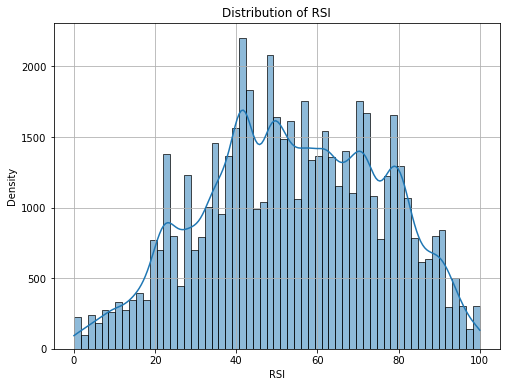

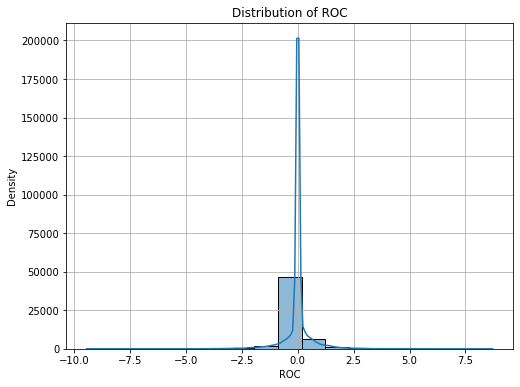

In [40]:
from talib import RSI, ROC
# Calculate RSI with a 14-period window
my_dataframe['rsi'] = RSI(my_dataframe['close'], timeperiod=14)

# Calculate ROC with a 12-period window
my_dataframe['roc'] = ROC(my_dataframe['close'], timeperiod=12)

# Backward fill missing values in the RSI column
my_dataframe['rsi'].fillna(method='bfill', inplace=True)

# Backward fill missing values in the ROC column
my_dataframe['roc'].fillna(method='bfill', inplace=True)

# Plot the distribution of RSI values
plt.figure(figsize=(8, 6))
sns.histplot(my_dataframe['rsi'], kde=True)
plt.xlabel('RSI')
plt.ylabel('Density')
plt.title('Distribution of RSI')
plt.grid(True)
plt.show()

# Plot the distribution of ROC values
plt.figure(figsize=(8, 6))
sns.histplot(my_dataframe['roc'], kde=True)
plt.xlabel('ROC')
plt.ylabel('Density')
plt.title('Distribution of ROC')
plt.grid(True)
plt.show()

In [ ]:
#TODO: Adding RSI: relative strenght index feature
#      Adding ROC feature 


# Calculate the RSI (with a 14-period window as default)
#tmp["rsi"] = ta.momentum.RSIIndicator(close=data["price"]).rsi()

# Calculate the ROC (with a 12-period window as default)
#tmp["roc"] = talib.momentum.ROCIndicator(close=data["close"]).roc()



In [41]:
#Adding day name
import calendar
my_dataframe["day_name"] = my_dataframe['Date'].apply(lambda x: calendar.day_name[x.weekday()])

In [ ]:
#TODO
#Add more features like:
    #Bollinger Bands
    #Average True Range
#If you have any interesting features to compute, just do it ! be free


>Compute Bollinger Bands

In [45]:
# Calculate Bollinger Bands
upper_band, middle_band, lower_band = BBANDS(my_dataframe['close'])
my_dataframe['upper_band'] = upper_band
my_dataframe['middle_band'] = middle_band
my_dataframe['lower_band'] = lower_band 

# Backward fill missing values in the RSI column
my_dataframe['upper_band'].fillna(method='bfill', inplace=True)
my_dataframe['middle_band'].fillna(method='bfill', inplace=True)
my_dataframe['lower_band'].fillna(method='bfill', inplace=True)


"upper_band, middle_band, lower_band = BBANDS(my_dataframe['close'])\nmy_dataframe['upper_band'] = upper_band\nmy_dataframe['middle_band'] = middle_band\nmy_dataframe['lower_band'] = lower_band \n\n# Backward fill missing values in the RSI column\nmy_dataframe['upper_band'].fillna(method='bfill', inplace=True)\nmy_dataframe['middle_band'].fillna(method='bfill', inplace=True)\nmy_dataframe['lower_band'].fillna(method='bfill', inplace=True)"

>Calculate Average True Range

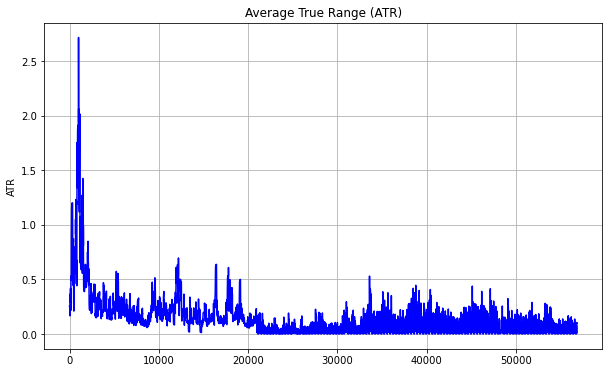

In [48]:
# Calculate Average True Range
atr = NATR(my_dataframe['high'], my_dataframe['low'], my_dataframe['close'])
my_dataframe['atr'] = atr

#Backward fill missing values in the ATR column
my_dataframe['atr'].fillna(method='bfill', inplace=True)

# Plot ATR
plt.figure(figsize=(10, 6))
plt.plot(my_dataframe.index, my_dataframe['atr'], color='blue')
plt.title('Average True Range (ATR)')
plt.ylabel('ATR')
plt.grid(True)
plt.show()

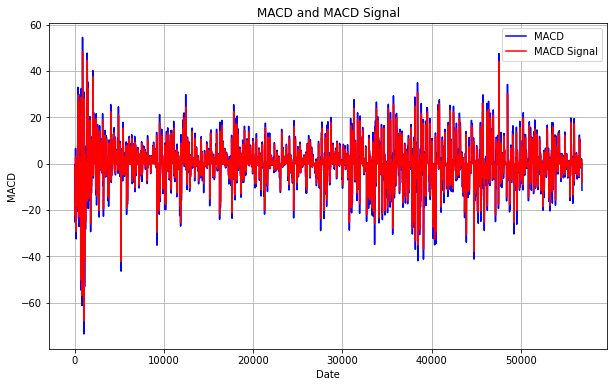

In [50]:
#Moving Average Convergence Divergence (MACD)
macd, macd_signal, _ = MACD(my_dataframe['close'])
my_dataframe['macd'] = macd
my_dataframe['macd_signal'] = macd_signal

#Forward and Backward fill missing values in the MACD column
my_dataframe['macd'].fillna(method='ffill', inplace=True)
my_dataframe['macd_signal'].fillna(method='ffill', inplace=True)
my_dataframe['macd'].fillna(method='bfill', inplace=True)
my_dataframe['macd_signal'].fillna(method='bfill', inplace=True)

# Plot MACD and MACD Signal
plt.figure(figsize=(10, 6))
plt.plot(my_dataframe.index, my_dataframe['macd'], label='MACD', color='blue')
plt.plot(my_dataframe.index, my_dataframe['macd_signal'], label='MACD Signal', color='red')
plt.title('MACD and MACD Signal')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)
plt.show()

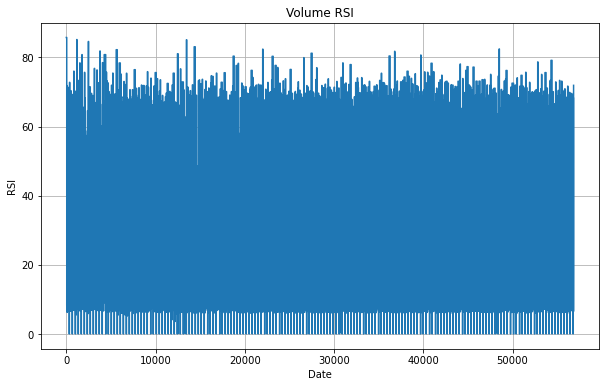

In [51]:
#Relative Strength Index (RSI) of Volume
volume_rsi = RSI(my_dataframe['volume'])
my_dataframe['volume_rsi'] = volume_rsi

#Backward fill missing values in the RSI of Volume column
my_dataframe['volume_rsi'].fillna(method='bfill', inplace=True)

# Plot Volume RSI
plt.figure(figsize=(10, 6))
sns.lineplot(data=my_dataframe, x=my_dataframe.index, y='volume_rsi')
plt.title('Volume RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid(True)
plt.show()

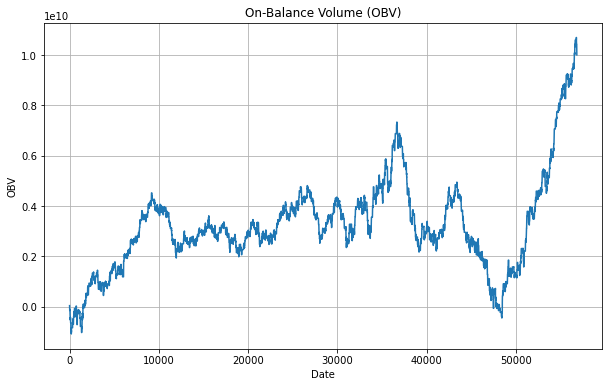

In [52]:
#On-Balance Volume (OBV)
obv = OBV(my_dataframe['close'], my_dataframe['volume'])
my_dataframe['obv'] = obv

#Backward fill missing values in the OBV column
my_dataframe['obv'].fillna(method='bfill', inplace=True)

# Plot OBV
plt.figure(figsize=(10, 6))
sns.lineplot(data=my_dataframe, x=my_dataframe.index, y='obv')
plt.title('On-Balance Volume (OBV)')
plt.xlabel('Date')
plt.ylabel('OBV')
plt.grid(True)
plt.show()

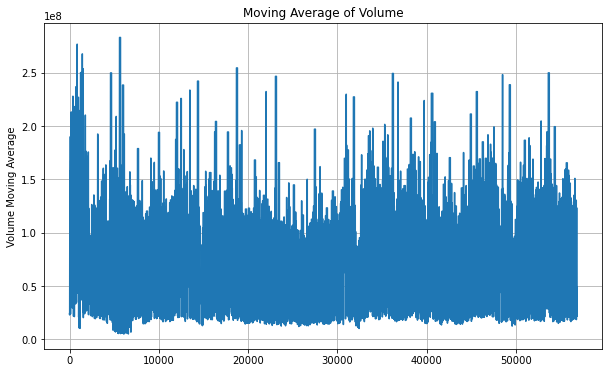

In [53]:
#Moving Average of Volume:
volume_ma = my_dataframe['volume'].rolling(window=10).mean()
my_dataframe['volume_ma'] = volume_ma

#Backward fill missing values in the volume_ma column
my_dataframe['volume_ma'].fillna(method='bfill', inplace=True)

# Plot moving average of volume
plt.figure(figsize=(10, 6))
sns.lineplot(data=my_dataframe, x=my_dataframe.index, y='volume_ma')
plt.title('Moving Average of Volume')
plt.ylabel('Volume Moving Average')
plt.grid(True)
plt.show()

In [ ]:
dff = my_dataframe.copy()

>Evaluate mutual information

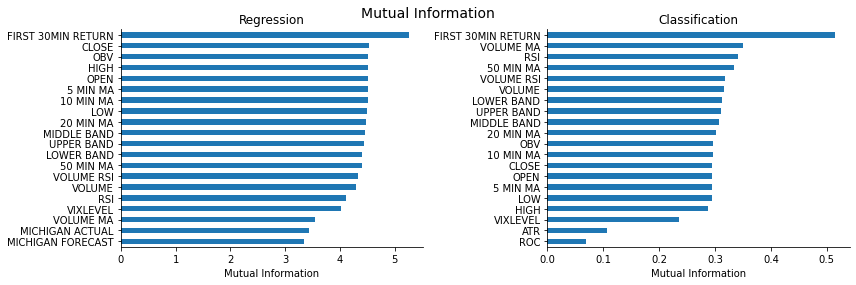

In [55]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

X = my_dataframe.drop(['last_30min_return', 'timestamp','key_0','date','Date','Time','day_name'], axis=1)

mi_reg = pd.Series(mutual_info_regression(X=X, y=my_dataframe['last_30min_return']), index=X.columns)
top_mi_reg = mi_reg.nlargest(10)

mi_class = pd.Series(mutual_info_classif(X=X, y=(my_dataframe['last_30min_return'] > 0).astype(int)), index=X.columns)
top_mi_class = mi_class.nlargest(10)

mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')

fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

In [ ]:
my_dataframe

In [56]:
#Download the required NLTK resources and set up the stop words
import nltk
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
# Define the function to extract text from a PDF file
def extract_text_from_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in range(len(reader.pages)):
            text += reader.pages[page].extract_text()
        return text

In [58]:
# Define the function to calculate average sentiment for a given text
def calculate_average_sentiment(text):
    # Tokenize the sentences
    sentences = sent_tokenize(text)

    # Tokenize words in each sentence and remove stop words
    stop_words = set(stopwords.words('english'))
    sentences = [word_tokenize(sent) for sent in sentences]
    sentences = [[word for word in sent if word.lower() not in stop_words] for sent in sentences]

    # Initialize the sentiment analysis pipeline
    nlp = pipeline("sentiment-analysis", model="textattack/bert-base-uncased-imdb")

    sentiments = []

    for sent in sentences:
        # Get the sentiment of the sentence
        result = nlp(sent)[0]
        # The sentiment is a value between -1 and 1, where -1 is very negative and 1 is very positive
        sentiment = 1 if result['label'] == 'POSITIVE' else -1
        sentiment *= result['score']  # Multiply by the confidence of the prediction
        sentiments.append(sentiment)

    average_sentiment = np.mean(sentiments)
    return average_sentiment

In [59]:
# Set the directory path where the Fed minutes files are stored
fedmindirectory = 'C:/Users/dell/Desktop/fed_minutes/'

In [60]:
# Create an empty dataframe to store date and average_sentiment
sentiment_df = pd.DataFrame(columns=['date', 'average_sentiment'])

In [61]:
# Iterate over the Fed minutes files
for filename in os.listdir(fedmindirectory):
    if filename.startswith('fomcminutes'):
        # Extract the date from the file name using regular expressions
        match = re.search(r'fomcminutes(\d+)', filename)
        if match:
            date = match.group(1)

            # Read the PDF file and extract text
            file_path = os.path.join(fedmindirectory, filename)
            fed_minutes = extract_text_from_pdf(file_path)

            # Calculate the average sentiment
            average_sentiment = calculate_average_sentiment(fed_minutes)

            # Append the date and average_sentiment to the sentiment_df dataframe
            sentiment_df = sentiment_df.append({'date': date, 'average_sentiment': average_sentiment}, ignore_index=True)

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.0.1+cpu)
    Python  3.9.13 (you have 3.9.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2085531929.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({'date': date, 'average_sentiment': average_sentiment}, ignore_index=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2085531929.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({'date': date, 'average_sentiment': average_sentimen

C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2085531929.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({'date': date, 'average_sentiment': average_sentiment}, ignore_index=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2085531929.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({'date': date, 'average_sentiment': average_sentiment}, ignore_index=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2085531929.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({'date': date, 'average_sentiment': average_sentiment}, ignore_index=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_7760\2085531929.py:17: F

In [62]:
sentiment_df

,date,average_sentiment
0,20180131,-0.635043
1,20180321,-0.644369
2,20180502,-0.645178
3,20180613,-0.643231
4,20180801,-0.652635
5,20180926,-0.64329
6,20181108,-0.647664
7,20181219,-0.648693
8,20190130,-0.639931
9,20190320,-0.663638


In [63]:
sentiment_dataframe = sentiment_df.copy()

In [66]:
# sentiment_df dataframe has a column named 'date' containing dates in the format "yyyymmdd", so it needs to be changed to"yyyy-mm-dd"
sentiment_dataframe['date'] = pd.to_datetime(sentiment_dataframe['date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')


In [68]:
# I saved the sentiment_df into an excel file so that you don't have to run the above code since it takes a lot of time.
sentiment_dataframe.to_excel('C:/Users/dell/Desktop/Trading Project/sentiment_dataframe.xlsx', index=False)


In [88]:
#Convert the 'date' column in both dataframes to datetime format:
my_dataframe['date'] = pd.to_datetime(my_dataframe['date'])
sentiment_dataframe['date'] = pd.to_datetime(sentiment_dataframe['date'])

#Create a new column in my_dataframe to hold the average sentiment values:
my_dataframe['average_sentiment'] = np.nan

#Iterate over each row in sentiment_df and assign the average sentiment value to all days of the corresponding month in my_dataframe
for index, row in sentiment_dataframe.iterrows():
    year = row['date'].year
    month = row['date'].month
    average_sentiment = row['average_sentiment']
    my_dataframe.loc[(my_dataframe['date'].dt.year == year) & (my_dataframe['date'].dt.month == month), 'average_sentiment'] = average_sentiment

#f
my_dataframe['average_sentiment'].fillna(method='bfill', inplace=True)
my_dataframe['average_sentiment'].fillna(method='ffill', inplace=True)

In [90]:
# Check for NaN values in the dataset
nan_check = my_dataframe.isna().any()

# Print the columns with NaN values
print(nan_check)

key_0                 False
timestamp             False
gmtoffset             False
open                  False
high                  False
low                   False
close                 False
volume                False
date                  False
vixLevel              False
GDP_ACTUAL            False
GDP_FORECAST          False
isGdpRelease          False
MICHIGAN_ACTUAL       False
MICHIGAN_FORECAST     False
isMichiganRelease     False
CPI_ACTUAL            False
isCpiRelease          False
Date                  False
Time                  False
last_30min_return     False
first_30min_return    False
5_min_MA              False
10_min_MA             False
20_min_MA             False
50_min_MA             False
rsi                   False
roc                   False
day_name              False
upper_band            False
middle_band           False
lower_band            False
atr                   False
macd                  False
macd_signal           False
volume_rsi          

In [91]:
test_dframe = my_dataframe.copy()

In [94]:
my_dataframe.to_hdf('C:/Users/dell/Desktop/Trading Project/my_dataframe.h5', key='data', mode='w')

C:\Users\dell\AppData\Local\Temp\ipykernel_7760\3360037281.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['key_0', 'Date', 'Time', 'day_name'], dtype='object')]

  my_dataframe.to_hdf('C:/Users/dell/Desktop/Trading Project/my_dataframe.h5', key='data', mode='w')


>Random Forest

In [93]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into features (X) and target variable (y)
X = test_dframe.drop(['last_30min_return', 'timestamp','key_0','date','Date','Time','day_name'], axis=1)
y = test_dframe['last_30min_return']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the random forest model
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
print("Random Forest MSE:", rf_mse)

# Train a bagging model with random forest as the base estimator
bagging_model = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, max_depth=5,
                                                                      min_samples_split=2, random_state=42),
                                 n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)

# Evaluate the bagging model
bagging_predictions = bagging_model.predict(X_test)
bagging_mse = mean_squared_error(y_test, bagging_predictions)
print("Bagging MSE:", bagging_mse)

# Train an AdaBoost model with random forest as the base estimator
adaboost_model = AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=100, max_depth=5,
                                                                        min_samples_split=2, random_state=42),
                                   n_estimators=10, learning_rate=0.1, random_state=42)
adaboost_model.fit(X_train, y_train)

# Evaluate the AdaBoost model
adaboost_predictions = adaboost_model.predict(X_test)
adaboost_mse = mean_squared_error(y_test, adaboost_predictions)
print("AdaBoost MSE:", adaboost_mse)


Random Forest MSE: 1.4930011082154559e-06
Bagging MSE: 1.3532815016577604e-06
AdaBoost MSE: 1.194822610434149e-06


In [2]:
# Load the dataset from the HDF5 file
saved_df = pd.read_hdf('C:/Users/dell/Desktop/Trading Project/my_dataframe.h5')

In [3]:
saved_df

,key_0,timestamp,gmtoffset,open,high,low,close,volume,date,vixLevel,...,upper_band,middle_band,lower_band,atr,macd,macd_signal,volume_rsi,obv,volume_ma,average_sentiment
0,2020-02-24,1.582556e+09,0.0,3256.689940,3256.830080,3251.489990,3254.600100,36716671.0,2020-02-24,25.810000,...,3257.805146,3246.356006,3234.906866,0.254242,-3.423414,-4.750009,85.779963,3.671667e+07,24170885.6,-0.651588
1,2020-02-24,1.582558e+09,0.0,3247.649900,3248.870120,3244.510010,3245.389890,31269796.0,2020-02-24,25.810000,...,3257.805146,3246.356006,3234.906866,0.254242,-3.423414,-4.750009,85.779963,5.446875e+06,24170885.6,-0.651588
2,2020-02-24,1.582560e+09,0.0,3249.189940,3250.229980,3248.020020,3249.580080,24787790.0,2020-02-24,25.810000,...,3257.805146,3246.356006,3234.906866,0.254242,-3.423414,-4.750009,85.779963,3.023466e+07,24170885.6,-0.651588
3,2020-02-24,1.582562e+09,0.0,3247.419920,3247.520020,3243.879880,3244.939940,21411709.0,2020-02-24,25.810000,...,3257.805146,3246.356006,3234.906866,0.254242,-3.423414,-4.750009,85.779963,8.822956e+06,24170885.6,-0.651588
4,2020-02-24,1.582563e+09,0.0,3235.080080,3241.419920,3232.590090,3237.270020,24604999.0,2020-02-24,25.810000,...,3257.805146,3246.356006,3234.906866,0.254242,-3.423414,-4.750009,85.779963,-1.578204e+07,24170885.6,-0.651588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56839,2023-05-23,1.684866e+09,0.0,4144.879882,4150.890136,4142.540039,4148.660156,27731000.0,2023-05-23,18.399999,...,4182.820159,4163.966015,4145.111872,0.102555,-8.331814,-4.641994,25.667411,1.029196e+10,23538536.5,-0.656319
56840,2023-05-23,1.684868e+09,0.0,4152.140136,4153.330078,4151.529785,4152.580078,18008000.0,2023-05-23,18.850000,...,4173.439797,4158.958008,4144.476218,0.103172,-9.311883,-5.575971,23.027816,1.030997e+10,22035281.9,-0.656319
56841,2023-05-23,1.684870e+09,0.0,4151.680175,4152.770019,4150.589843,4152.600097,22705000.0,2023-05-23,18.569999,...,4167.266963,4155.804004,4144.341045,0.099553,-9.972027,-6.455183,26.936758,1.033267e+10,21573732.5,-0.656319
56842,2023-05-23,1.684872e+09,0.0,4148.709960,4149.930175,4145.600097,4145.970214,160367000.0,2023-05-23,18.409999,...,4163.326887,4152.384082,4141.441277,0.104649,-10.904473,-7.345041,71.929951,1.017231e+10,35228180.6,-0.656319


>Linear Regression Model

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Split the data into features (X) and target variable (y)
X = saved_df.drop(['last_30min_return', 'timestamp','key_0','date','Date','Time','day_name'], axis=1)
y = saved_df['last_30min_return']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model
linear_model = LinearRegression()

# Perform GridSearchCV for hyperparameter tuning
parameters = {
    'linearregression__fit_intercept': [True, False],
    'linearregression__normalize': [True, False]
}

model = make_pipeline(StandardScaler(with_mean=False), linear_model)

grid_search = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train a Linear Regression model with the best hyperparameters
linear_model_best = make_pipeline(StandardScaler(with_mean=False), LinearRegression(fit_intercept=best_params['linearregression__fit_intercept'], normalize=best_params['linearregression__normalize']))
linear_model_best.fit(X_train, y_train)

# Evaluate the Linear Regression model with the best hyperparameters
linear_predictions = linear_model_best.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_predictions)
print("Linear Regression MSE:", linear_mse)


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = m

C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Plea

Linear Regression MSE: 2.1535946012253305e-06


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


>SVM model using the Support Vector Regression (SVR) algorithm

In [8]:
from sklearn.svm import SVR

# Split the data into features (X) and target variable (y)
X = saved_df.drop(['last_30min_return', 'timestamp','key_0','date','Date','Time','day_name'], axis=1)
y = saved_df['last_30min_return']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize the SVM model
model = SVR()

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Retrieve the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred)
print("Best Parameters:", best_params)
print("Mean Squared Error:", mse)

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mean Squared Error: 0.0003018368767537839
